<a href="https://colab.research.google.com/github/samikshae/seportfolio/blob/main/EmotionDetection_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import dlib
import gdown
import pickle
import warnings
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

import urllib.request

from sklearn import metrics


from scipy.spatial import distance
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

###Getting the csv data loaded
!wget -q --show-progress -O ./ferdata.csv "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/fer2013_5.csv"

###Getting the Dlib Shape predictor!
!wget -q --show-progress -O ./shape_predictor_68_face_landmarks.dat "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat"

###Getting the Xpure loaded
!wget -q --show-progress -O ./pureX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/pureX.npy"

###Getting the Xdata loaded
!wget -q --show-progress -O ./dataX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataX_edited.npy"

###Getting the Ydata loaded
!wget -q --show-progress -O ./dataY.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataY.npy"

print ("Data Downloaded!")


./ferdata.csv       100%[===================>] 159.97M  87.2MB/s    in 1.8s    
./shape_predictor_6 100%[===================>]  95.08M  95.4MB/s    in 1.0s    
./pureX.npy         100%[===================>]  43.95M  67.8MB/s    in 0.6s    
./dataX.npy         100%[===================>] 347.59M  80.0MB/s    in 4.2s    
./dataY.npy         100%[===================>] 156.38K  --.-KB/s    in 0.008s  
Data Downloaded!


In [ ]:
Q1 = "4624" #@param ["2278","4556","4624","68","Fill Me In"]

Q2 = "2278" #@param ["2278","4556","4624","68","Fill Me In"]

if Q1 == '4624':
  print('Yes! 68 * 68 = 4624.')
else:
  print('Try Again')

if Q2 == "2278":
  print("Thats Right! If we exclude the distance of points with itself and repeats, we will have 67+66+65+...+1 = 2278 distance values")
else:
  print('Try again!')

Yes! 68 * 68 = 4624.
Thats Right! If we exclude the distance of points with itself and repeats, we will have 67+66+65+...+1 = 2278 distance values


In [ ]:
#Integer to Label Mapping
label_map = {0:"ANGRY",1:"HAPPY",2:"SAD",3:"SURPRISE",4:"NEUTRAL"}

#Load the datala
df = pd.read_csv("./ferdata.csv")
df.head()

,emotion,pixels,Usage
0,0,215 216 215 215 215 216 216 216 214 178 81 30 ...,Training
1,4,244 244 244 244 243 244 242 190 132 93 81 73 7...,Training
2,4,255 255 255 255 255 255 255 255 255 255 255 25...,Training
3,4,38 56 60 52 58 65 53 44 35 48 59 60 36 30 21 3...,Training
4,4,77 40 27 21 22 25 20 31 27 17 27 42 47 55 51 4...,Training


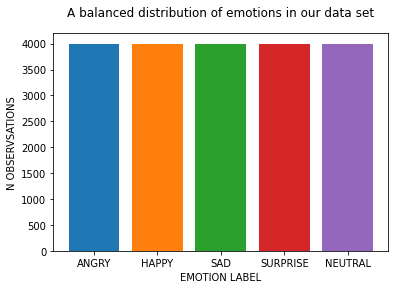

In [ ]:
# generate x labels for our plot
emotion_labels = [label_map[i] for i in label_map.keys()]

# generate counts for each emotion type
emotion_counts = [np.sum(df["emotion"] == i) for i in range(len(label_map))]

# generate a bar plot for our emotion labels that has different colors
[plt.bar(x = emotion_labels[i], height = emotion_counts[i] ) for i in range(len(emotion_labels))]

# make the plot interpretable with x and y labels + title
plt.xlabel('EMOTION LABEL')
plt.ylabel('N OBSERVSATIONS')
plt.title('A balanced distribution of emotions in our data set', y=1.05);

In [ ]:
# Load's dlib's pretrained face detector model
#frontalface_detector = dlib.get_frontal_face_detector()


#Load the 68 face Landmark file
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):


  #:type image : cv2 object
  #:rtype landmarks : list of tuples where each tuple represents
  #                  the x and y co-ordinates of facial keypoints

  #Bounding Box co-ordinates around the face(Training data is 48*48(cropped faces))
  rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]

  #Read Image using OpenCV
  #image = cv2.imread(image_path)
  #Detect the Faces within the image
  landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
  return image,landmarks

"""
Display image with its Facial Landmarks
"""
def plot_image_landmarks(image,face_landmarks):
  """
  :type image_path : str
  :type face_landmarks : list of tuples where each tuple represents
                     the x and y co-ordinates of facial keypoints
  :rtype : None
  """
  radius = -2
  circle_thickness = 1
  image_copy = image.copy()
  for (x, y) in face_landmarks:
    cv2.circle(image_copy, (x, y), circle_thickness, (255,0,0), radius)

  plt.imshow(image_copy, interpolation='nearest', cmap='Greys_r')
  plt.xticks([]); plt.yticks([])
  plt.show()


'''
Converts pixels values to 2D-image.
Displays the image and returns the cv2 image
object
'''
def get_pixels_image(img_pixels,plt_flag):
  """
  :type image_pixels : str
  :type plt_flag : boolean
  :rtype image : cv2 object
  """

  width = 48
  height = 48

  image = np.fromstring(img_pixels, dtype=np.uint8, sep=" ").reshape((height, width))

  if plt_flag:
      plt.imshow(image, interpolation='nearest', cmap="Greys_r")
      plt.xticks([]); plt.yticks([])
      plt.show()


  return image


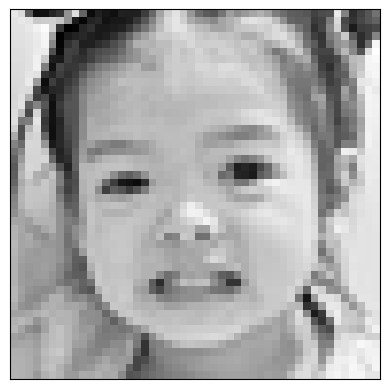

In [ ]:
# select random index
i_index = np.random.randint(len(df))

# extract pixel values
image_pixels = df['pixels'][i_index]

# convert pixels to 2D Images
image = get_pixels_image(image_pixels, True)

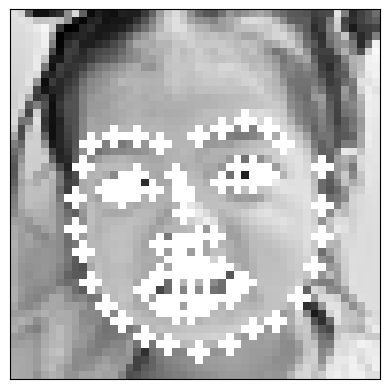

In [ ]:
#Extract the Facial Landmarks
image,facial_landmarks = get_landmarks(image)

#Display the Facial Landmarks on the Image
plot_image_landmarks(image,facial_landmarks)

In [ ]:
for i, j in itertools.combinations(range(4), 2):
  print(i, j)

0 1
0 2
0 3
1 2
1 3
2 3


In [ ]:
"""
Computes euclidean distance between 68 Landmark Points for our features
e_dist is a list of features that will go into our model.
Each feature is a distance between two landmark points, and every pair of points
must have a feature.
Scipy Library has readily available fuction to compute euclidean distance. You can
compute the distance using distance.euclidean(point1,point2)
point1,point2 :2D points
"""
def get_all_landmarks_euclid_dist(face_landmarks):

    e_dist = []
    for i, j in intertools.combinations(range(4), 2):
      distance.euclidean(face_landmarks[i],face_landmarks[j])

    # FILL ME IN!
    # Use this to get the distance between two points:
    #               distance.euclidean(face_landmarks[i],face_landmarks[j])

    return e_dist

In [ ]:
def preprocess_data(df):

  X = []
  Y = []
  X_pixels = []

  n_pixels = 2304

  for index, row in (df.iterrows()):

      if index%1000 == 0:
        print (index, "Datapoints Processed")

      try:
          image = get_pixels_image(row['pixels'],0)
          X_pixels.append(image.ravel())
          image = cv2.GaussianBlur(image,(5,5),0)

          _,face_landmarks = get_landmarks(image)
          X.append(get_all_landmarks_euclid_dist(face_landmarks)) # Using our feature function!
          Y.append(row['emotion'])

      except Exception as e:
          print ("An error occured:",e)

  #Save the data
  np.save("pureX", X_pixels)
  np.save("dataX", X)
  np.save("dataY", Y)

  return np.array(X_pixels),np.array(X),np.array(Y)

In [ ]:
# set to True if we want to preload data -- which has already been generated for us :)
preload = True

if preload:

  # load outputs saved in this folder after running preprocess_data()
  dataX = np.load('./dataX.npy')
  dataY = np.load('./dataY.npy', allow_pickle=True)

else:

  # this takes 15-20 minutes to run, but someone has already run it and saved the ouputs in this folder
  pureX, dataX, dataY = preprocess_data(df)

In [ ]:
#Split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.1, random_state=42,stratify =dataY)

In [ ]:
####Standardize the data####################
###Note: Do not use test data to fit your Standardscaler Model
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(18000, 2278)

In [ ]:
#Reduces features by maintaining 95% variance of the data
#After doing PCA on our training data, 2278 Dimensions --->reduced to 20
#Note: PCA is trained only on training data
pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test= pca.transform(X_test)

In [ ]:
X_train.shape

In [ ]:
#@title How will our model operate? { display-mode: "form" }

#@markdown What are our inputs?
inputs = "distances between facial landmarks" #@param ["images", "facial landmarks", "distances between facial landmarks", "Fill Me In"]

#@markdown What are our outputs?
outputs = "integer encoded emotions" #@param ["integer encoded emotions", "images", "image edges", "Fill Me In"]

#@markdown What kind of problem will our AI model solve?
problem_type  = "classification" #@param ["classification", "regression","Fill Me In"]


if inputs == "distances between facial landmarks":
  print("Yes, our inputs are our distance between facial landmarks!")
else:
  print('Not quite our inputs.')

if outputs == "integer encoded emotions":
  print("Yes, our outputs are integer encoded emotions!")
else:
  print('Not quite our outputs.')

if problem_type == "classification":
  print("We are trying to predict labels, therefore this is classification!")
else:
  print('Not quite our problem!')

Yes, our inputs are our distance between facial landmarks!
Yes, our outputs are integer encoded emotions!
We are trying to predict labels, therefore this is classification!


In [ ]:
'''
Plots the confusion Matrix and saves it
Pass the true labels and the predicted labels
'''
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

In [ ]:
plot_confusion_matrix(y_test,y_predlr)

In [ ]:

#@markdown Name most correctly classified emotion?
correct_emotion = "Fill Me In"#@param ["Anger","Happy","Sad","Surprise", "Neutral", "Fill Me In"]

#@markdown Name most incorrectly classified emotion?
incorrect_emotion = "Fill Me In"#@param ["Anger","Happy","Sad","Surprise", "Neutral", "Fill Me In"]

#@markdown Sad Emotion is highly misclassified as?
sad_misclassify ="Fill Me In"#@param ["Anger","Happy","Sad","Surprise", "Neutral", "Fill Me In"]

#@markdown Neutral Emotion is highly misclassified as?
neutral_misclassify ="Fill Me In"#@param ["Anger","Happy","Sad","Surprise", "Neutral", "Fill Me In"]


#@markdown Angry Emotion is highly misclassified as?
angry_misclassify ="Fill Me In"#@param ["Anger","Happy","Sad","Surprise", "Neutral", "Fill Me In"]



In [ ]:
#Load the true pixel data and corresponding labels
X = np.load('pureX.npy')
Y = np.load('dataY.npy')

In [ ]:
# extract images as vectors, convert from strings to ints -- this is called a "list comprehension"
x_image = np.array( [np.fromstring(df['pixels'][i], dtype=np.uint8, sep=" ") for i in range(len(df))] )

# extract labels in the same way--through a list comprehension
y_image = np.array( [df['emotion'][i] for i in range(len(df)) ])

# generate train-test (90/10) splits
X_train, X_test, y_train, y_test = train_test_split(x_image, y_image, test_size=0.1,random_state=42)

# define the model
knn = KNeighborsClassifier(n_neighbors=10)

# train
print ("training knn model ...")
knn.fit(X_train, y_train)

# test
print ("Predict for KNN Model")
y_pred_knn = knn.predict(X_test)

# display results
print ("KNN Test Accuracy on raw image inputs:", metrics.accuracy_score(y_test, y_pred_knn))